In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_legendre
from tqdm import tqdm

import mu2

import constants as const
from interaction import potential
from counterterm import local_LO_counterterm
from mottmassey import mm_potential

gr = 4/3
h = 3

plt.style.use('science')

In [2]:
lo_rg_flow = np.loadtxt('rgflow_local_lo_a0_fix.txt')
nlo_rg_flow = np.loadtxt('rgflow_local_nlo_a0_B6_fix.txt')

ell = 0

In [3]:
rmesh = mu2.Mesh(0, 10*const.BETA4, 2000)
systems = []
for (Ri, _) in tqdm(lo_rg_flow):
    qmesh = mu2.Mesh(0, 20*2/Ri, 300, log=False)
    x = mu2.LocalCounterterm(local_LO_counterterm, lambda r, R: 0, rmesh, qmesh, Ri, ell)
    
    systems.append(mu2.System(mu2.Interaction(potential, x, rmesh), const.MU, ell))

100%|███████████████████████████████████████████| 50/50 [03:51<00:00,  4.63s/it]


In [4]:
ks = np.linspace(0.01/const.BETA4, 1/const.BETA4, 30)
# ks = np.linspace(0.01/const.BETA4, 1/1.5, 50)
kcds_lo = []

for i in tqdm(range(len(systems))):
    s = systems[i]
    gi = lo_rg_flow[i, 1]
    kcds_lo.append(s.kcotd_gen_fast(ks, gi, 0))
#     kcds_lo.append(np.array([
#         mu2.cc.cscatter.kcotdelta_py(k, s.v_tilde + s.interaction.counterterm.gen(gi, 0),
#                                      s.q, s.wq, 20*2/s.r_c, ell, 2*const.MU) for k in ks]))

kcds_lo = np.array(kcds_lo)

100%|███████████████████████████████████████████| 50/50 [00:24<00:00,  2.04it/s]


In [5]:
kcds_nlo = []
for i in tqdm(range(len(systems))):
    s = systems[i]
    glo, gnlo = nlo_rg_flow[i, 1:]
    xterm = s.interaction.counterterm.gen(1, 0)
    kcds_nlo.append(np.array([
        mu2.cc.cscatter.kcotdelta_py(k, s.v_tilde + glo*xterm + gnlo*k**2/(2*const.MU)*xterm, 
                                  s.q, s.wq, 20*2/s.r_c, ell, 2*const.MU) for k in ks]))

kcds_nlo = np.array(kcds_nlo)

100%|███████████████████████████████████████████| 50/50 [00:24<00:00,  2.04it/s]


In [6]:
spec_mm = np.loadtxt('spectra_Mott_Massey.txt')

In [7]:
np.sqrt(-2*const.MU*spec_mm)

array([5.54937872, 4.58600143, 3.61010279, 2.64047583, 1.70542502,
       0.8621926 , 0.23909757])

In [8]:
10/const.BETA4, 1/1.5, np.sqrt(-2*const.MU*spec_mm[0]), np.sqrt(-2*const.MU*spec_mm[1])

(0.30571790743731025, 0.6666666666666666, 5.549378722012561, 4.586001427296741)

In [9]:
mm = mu2.System(
    mu2.Interaction(lambda r, R: mm_potential(r),
        mu2.LocalCounterterm(lambda r, R: 0, lambda r, R: 0, rmesh, mu2.Mesh(0, 20*2/1.5, 300), 1.5, 0),
        rmesh
    ), const.MU, 0
)

kcds_mm = np.array([mu2.cc.cscatter.kcotdelta_py(k, mm.v_tilde, mm.q, mm.wq, 20*2/1.5, 0, 2*const.MU) for k in ks])

In [18]:
from scipy.optimize import curve_fit

In [50]:
def effective_range_parameters(kcd):
    pars, cov = curve_fit(lambda k, ia0, r0: -ia0 + r0/2*k**2, ks, kcd)
    sigma = np.diag(cov)
    return pars, sigma

In [51]:
pars, sig = effective_range_parameters(kcds_mm)

In [52]:
for (p, s) in zip(pars, sig):
    print(f'{p:.2e} ± {s:.2e}')

-1.57e-02 ± 1.81e-07
1.67e+02 ± 3.90e+00


In [53]:
ii = np.where(const.BETA4/lo_rg_flow[:, 0] < 30)[0]

In [54]:
const.BETA4

32.70989286766126

In [56]:
for kcd in kcds_nlo:
    pars, sig = effective_range_parameters(kcd)
    print(1/pars[0], pars[1])

-63.72185965930347 166.59842343314966
-63.72379986048565 166.60156138836496
-63.72673496184983 166.61789373598182
-63.7287260715011 166.63517831869572
-63.73326376598004 166.65129015675367
-63.737628817568414 166.65823938334552
-63.736100683713346 166.65326789751896
-63.73438948872483 166.64968883179873
-63.7344364409695 166.65021930754702
-63.736750394977385 166.66037655794904
-63.746712818009236 166.6811789892852
-63.75014743447429 166.6898313442774
-63.74921452289311 166.6916468712986
-63.749685642988574 166.68283162346216
-63.74545993947211 166.67233789153823
-63.739961942443344 166.66200356909098
-63.740553691644166 166.66549880594076
-63.74985752120126 166.6799908959754
-63.7600462912924 166.69738819402647
-63.766242944777055 166.7132428211274
-63.77043677279308 166.7258207261135
-63.77252775153904 166.73332597954462
-63.770800783411616 166.7293139067677
-63.765326122508554 166.70673964933565
-63.75441375245869 166.675706959211
-63.74213698352319 166.64478741884793
-63.7322864766

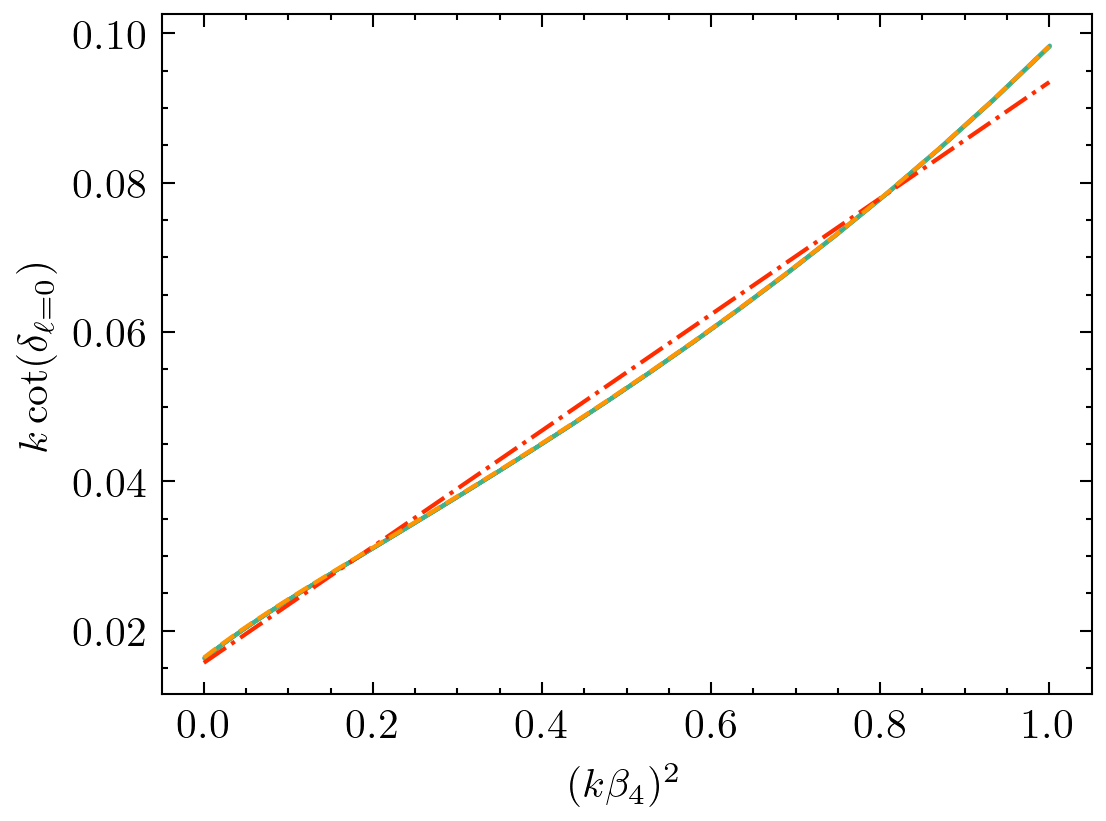

In [65]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=300)
fig.patch.set_facecolor('white')

ax.plot((ks*const.BETA4)**2, -pars[0] + pars[1]/2*ks**2, linestyle='-.', color='C3')

low_lo, med_lo, high_lo = np.quantile(kcds_lo[ii, :], [0.16, 0.5, 0.84], axis=0)
ax.fill_between((ks*const.BETA4)**2, low_lo, high_lo, color='C0', alpha=0.5, label='LO')

low_nlo, med_nlo, high_nlo = np.quantile(kcds_nlo[ii, :], [0.16, 0.5, 0.84], axis=0)
ax.fill_between((ks*const.BETA4)**2, low_nlo, high_nlo, color='C1', alpha=0.5, label='NLO')
    
ax.plot((ks*const.BETA4)**2, kcds_mm, color='C2', linestyle='--', label='MM')

# ax.legend()
# ax.set_ylim([-1, 1])
# ax.set_xlim([40, 1600])
# ax.set_xscale('log')
ax.set_xlabel(r'$(k\beta_4)^2$')
ax.set_ylabel(r'$k\cot(\delta_{\ell=0})$');

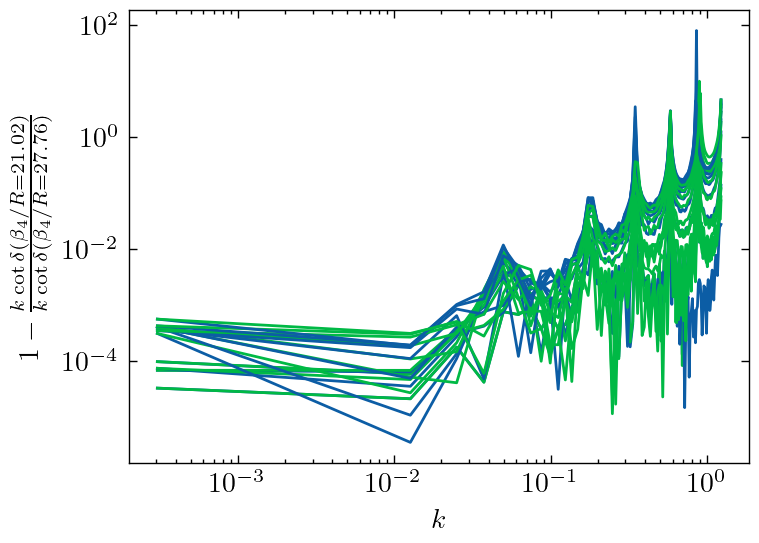

In [23]:
i = 18

fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for j in range(19, 30):
    rel_diff_lo = np.abs(1 - kcds_lo[j, :]/kcds_lo[i, :])
    rel_diff_nlo = np.abs(1 - kcds_nlo[j, :]/kcds_nlo[i, :])
    ax.plot(ks, rel_diff_lo , color='C0')
    ax.plot(ks, rel_diff_nlo, color='C1')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$1 - \frac{k\cot\delta(\beta_4/R=%.2f)}{k\cot\delta(\beta_4/R=%.2f)}$' %
              (const.BETA4/lo_rg_flow[i, 0], const.BETA4/nlo_rg_flow[j, 0]));

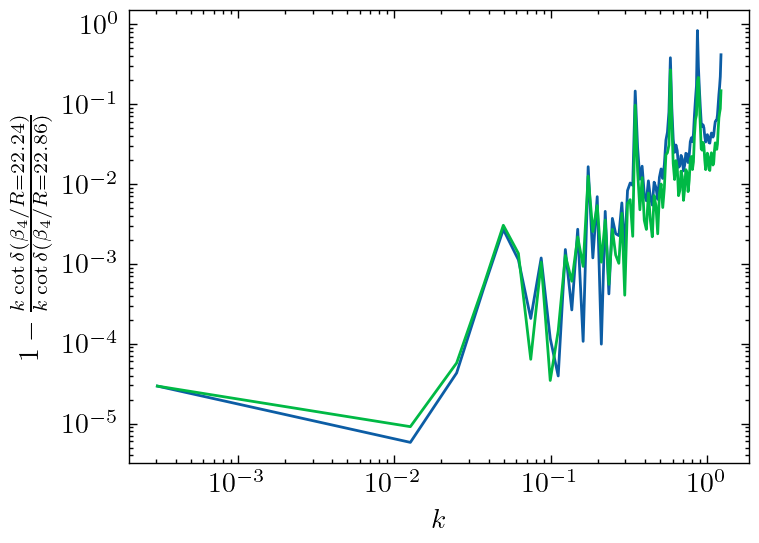

In [24]:
i = 20

fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for j in range(21, 22):
    ax.plot(ks, np.abs(1 - kcds_lo[j, :]/kcds_lo[i, :]), color='C0')
    ax.plot(ks, np.abs(1 - kcds_nlo[j, :]/kcds_nlo[i, :]), color='C1')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$1 - \frac{k\cot\delta(\beta_4/R=%.2f)}{k\cot\delta(\beta_4/R=%.2f)}$' %
              (const.BETA4/lo_rg_flow[i, 0], const.BETA4/nlo_rg_flow[j, 0]));

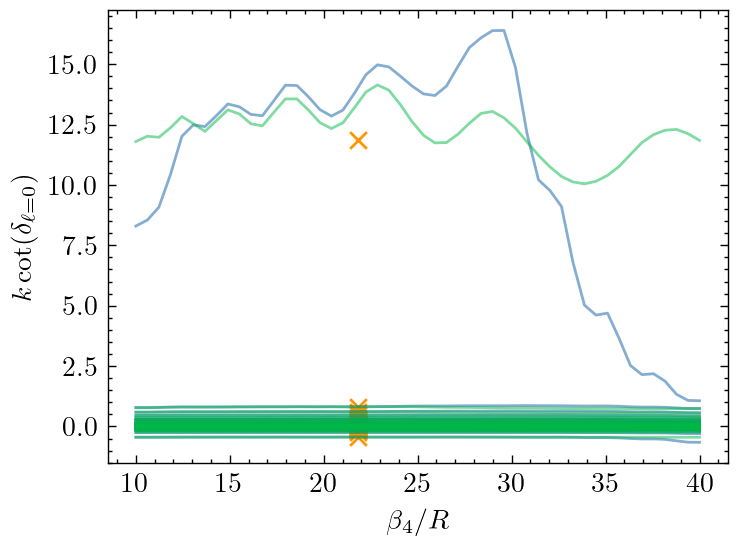

In [69]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for kcd in kcds_lo.T:
    ax.plot(const.BETA4/lo_rg_flow[:, 0], kcd, color='C0', alpha=0.5)

for kcd in kcds_nlo.T:
    ax.plot(const.BETA4/lo_rg_flow[:, 0], kcd, color='C1', alpha=0.5)

ax.scatter(np.ones(ks.size)*const.BETA4/1.5, kcds_mm, color='C2', marker='x')
# ax.axvline(const.BETA4/1.5)
# ax.set_xlim([21, 23])
# ax.set_ylim([-3, 6])
ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$k\cot(\delta_{\ell=0})$');

In [74]:
jj = np.argmin(np.abs(const.BETA4/lo_rg_flow[:, 0] - 25))

In [75]:
jj

25

In [85]:
deltas_mm = np.arctan(ks/kcds_mm)

In [86]:
def phase_shift(kcd, k):
    return np.arctan(k/kcd)

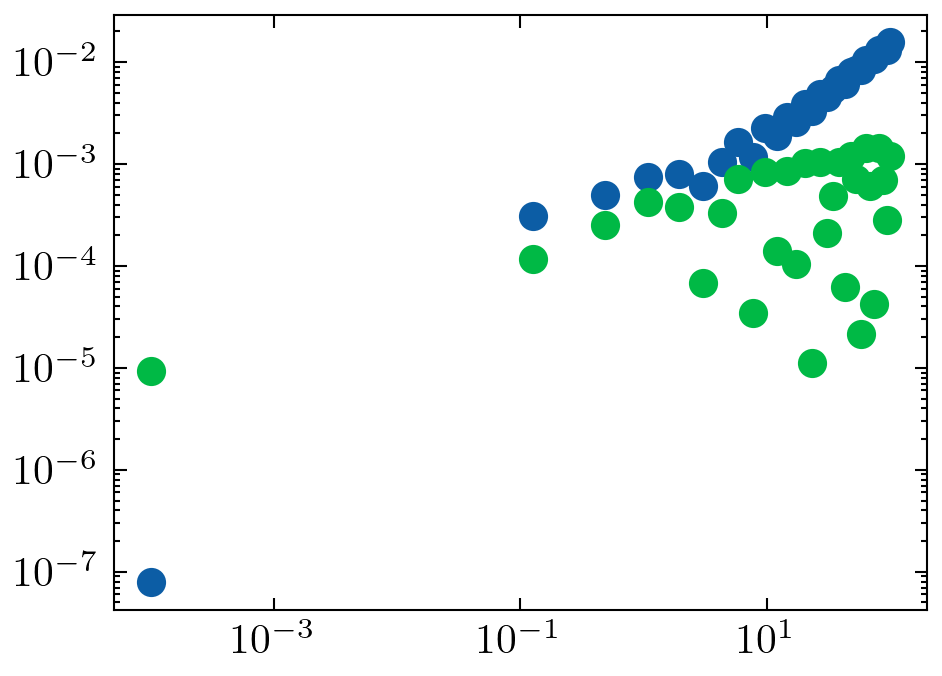

In [90]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_facecolor('white')

ax.scatter((ks*const.BETA4)**2, np.abs(phase_shift(kcds_lo[jj, :], ks) - deltas_mm))
ax.scatter((ks*const.BETA4)**2, np.abs(phase_shift(kcds_nlo[jj, :], ks) - deltas_mm))

ax.set_xscale('log')
ax.set_yscale('log');

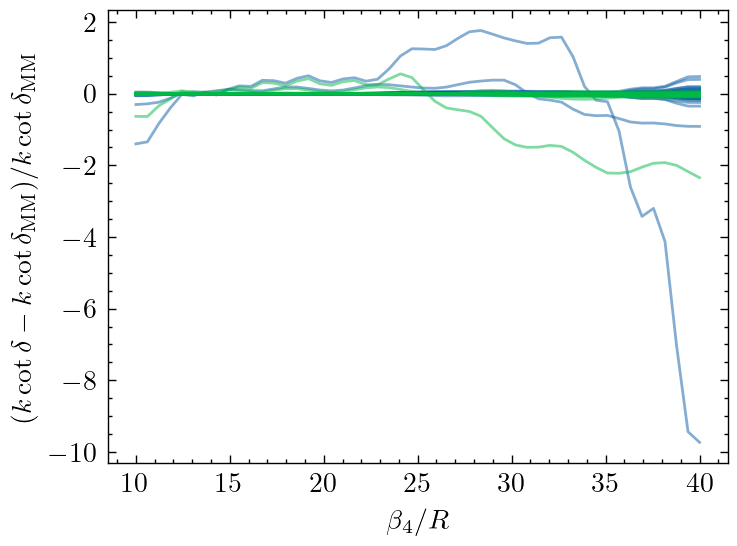

In [70]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for (i, kcd) in enumerate(kcds_lo.T):
    ax.plot(const.BETA4/lo_rg_flow[:, 0], (kcd - kcds_mm[i])/kcds_mm[i], color='C0', alpha=0.5)

for (i, kcd) in enumerate(kcds_nlo.T):
    ax.plot(const.BETA4/lo_rg_flow[:, 0], (kcd - kcds_mm[i])/kcds_mm[i], color='C1', alpha=0.5)

# ax.scatter(np.ones(30)*const.BETA4/1.5, kcds_mm, color='C2', marker='x')
# ax.axvline(const.BETA4/1.5)
# ax.set_xlim([21, 23])
# ax.set_ylim([0.016, 0.0241])
ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$(k\cot\delta - k\cot\delta_{\rm MM}) / k\cot\delta_{\rm MM}$');

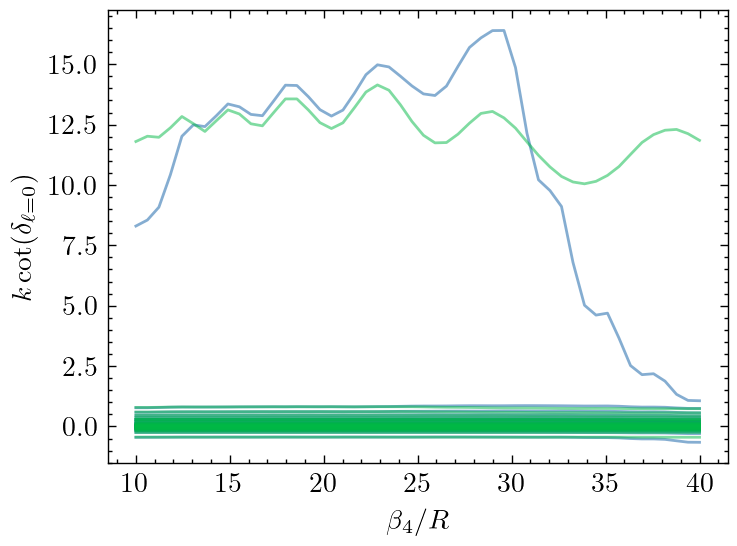

In [71]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for kcd in kcds_lo.T:
    ax.plot(const.BETA4/lo_rg_flow[:, 0], kcd, color='C0', alpha=0.5)

for kcd in kcds_nlo.T:
    ax.plot(const.BETA4/lo_rg_flow[:, 0], kcd, color='C1', alpha=0.5)
    
ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$k\cot(\delta_{\ell=0})$');

In [56]:
np.savetxt('kcd_lo.txt', np.vstack((lo_rg_flow[:, 0], kcds_lo.T)).T)

In [57]:
np.savetxt('kcd_nlo.txt', np.vstack((lo_rg_flow[:, 0], kcds_nlo.T)).T)

In [58]:
np.savetxt('momenta.txt', ks)

In [59]:
np.savetxt('kcd_mm.txt', mm.kcotd_gen_fast(ks, 0, 0))